In [38]:
#For development only, enables import of local package from parent dir
import os
import sys
sys.path.append(os.path.abspath('..'))

#For development only, enables fast reload of imported packages after code changes
%load_ext autoreload

#Example of final/desired import structure of GraphOty package
from GraphOty.OT import fused_wasserstein as fw, fused_gromov_wasserstein as fgw
from GraphOty.graph import random_GMM, SBM_Multiplex
from GraphOty.plot import plot_heatmap, hier_clustering, plot_emb

#Benchmark
from GraphOty.benchmark import knn

#External Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pathlib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
c = 10
d = 5

In [40]:
path = pathlib.Path().resolve()
save_path = path / "tmp"

multiplex_graphs = []
features = []
labels = []
patient_ids = []

feature_noise_scale = 2.5
adj_noise_scale = 0.5

inner_connectivity = 0.25
outer_connectivity = 0.1
n_graphs = 2
layers = 3
SBM1 = np.asarray([[10,10,5,5,0,0],[10,5,5,10,0,0],[5,5,10,10,0,0]]) * 5
SBM2 = np.asarray([[5,5,10,10,0,0],[5,10,10,5,0,0],[10,10,5,5,0,0]]) * 5
SBM3 = np.asarray([[15,15,0,0,0,0],[5,5,5,5,5,5],[30,0,0,0,0,0]]) * 5
#SBM4 = np.asarray([[0,0,15,15,0,0],[5,5,5,5,5,5],[30,0,0,0,0,0]]) * 10
#SBM1 = np.asarray([[10,10,5,5],[10,5,5,10],[5,5,10,10]]) * 6

classes = np.asarray([SBM1,SBM2,SBM3,SBM3])
average_block_size = np.mean(classes)
class_names = ["SBM1-F1","SBM2-F1","SBM3-F2","SBM3-F3"]
true_blocks = [None] * len(classes) # [[25,25,25,25,25,25]]

#Compute GMMs per SBM per Layer
GMMs = []
for sbm in classes:
    SBM_GMMs = []
    for layer_blocks in sbm:
        gmm, pts, true_components = random_GMM(len(layer_blocks),title=None,ax=None)
        SBM_GMMs.append(gmm)
    GMMs.append(SBM_GMMs)

#SBM1 and SBM2 have same feature dist
GMMs[0] = GMMs[1]


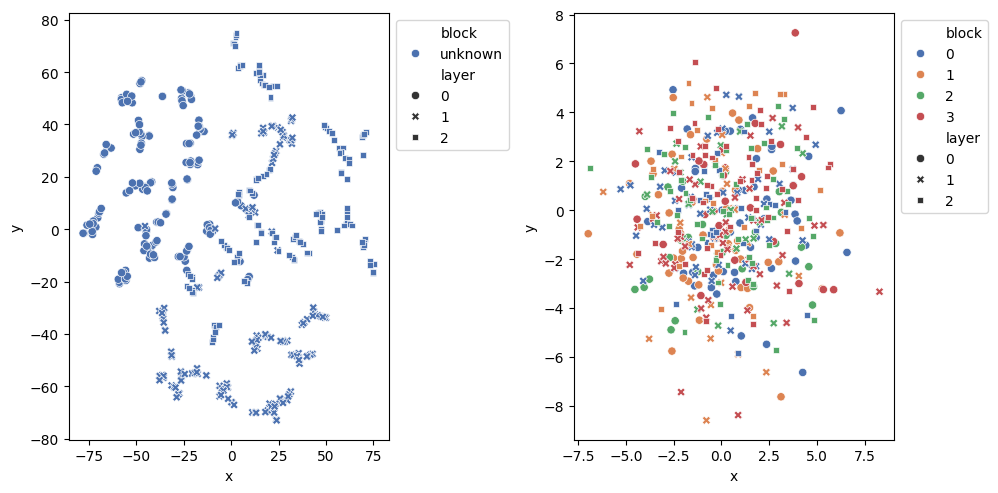

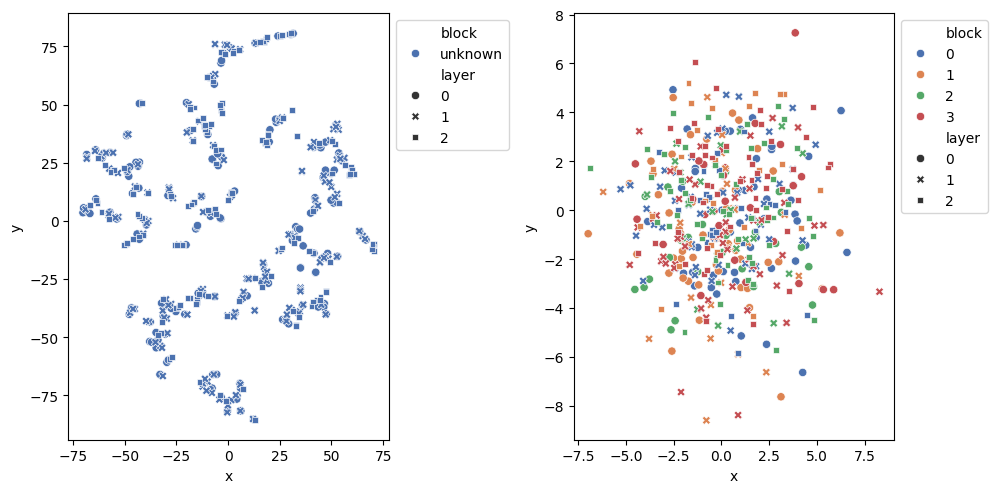

[STATUS] Started parsing edgelist...
[STATUS] Finished parsing edgelist in 0.0 seconds
[STATUS] Started preprocessing transition probabilities...
[STATUS] Finished preprocessing transition probabilities in 7.6 seconds
[STATUS] Started generating random walks...
[STATUS] Finished generating random walks in 42.6 seconds
[STATUS] Started learning and saving embeddings...
[STATUS] Saved embeddings to /home/kuehn/GraphOty/GraphOT/examples/tmp/0_0_embedded.csv
[STATUS] Finished learning and saving embeddings in 40.5 seconds
[STATUS] Completed multilayer network embedding in 90.8 seconds. See results in /home/kuehn/GraphOty/GraphOT/examples/tmp.
[150 300]


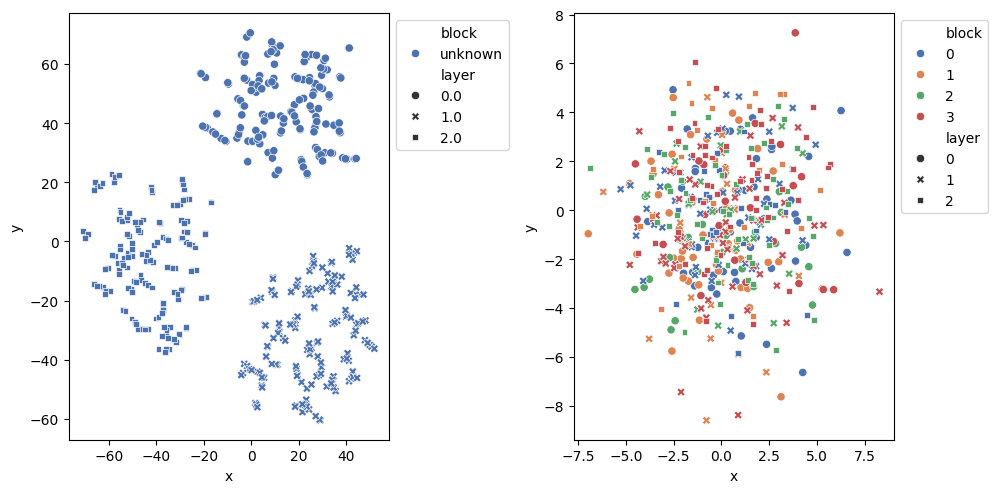

In [41]:

emb_times = {"CCB":[],"CNP":[],"HenHoe2Vec":[]}

for i,model in enumerate(classes):
    for g in range(n_graphs):
        labels.append(class_names[i])
        #Sample from SBM according to mixed blocks
        multiplex_graphs.append(SBM_Multiplex(layers=layers,attributes=True,blocks=model,self_connectivity = inner_connectivity,outer_connectivity = outer_connectivity,plot=False,example=True,feature_GMMs=GMMs[i],adj_noise_scale=adj_noise_scale,feature_noise_scale=feature_noise_scale))
        #multiplex_graphs[-1].plot_attributes(direction="vertical",example=True)

        #Compute high-dim strutural representation and plot 2D embedding of it

        
        #HenHoe2Vec
        #sampled_SBMs[id].structural_embedding(,ground_truth=true_blocks[i],)

        plot_embs = (g == 0) #only plot embs for the first graph of a class as an example

        multiplex_graphs[-1].structural_embedding(method="CCB",ground_truth=true_blocks[i],c=c,d=d,num_inits=100, plot=plot_embs)

        multiplex_graphs[-1].structural_embedding(method="CNP",ground_truth=true_blocks[i],c=c,d=d,num_inits=100, plot=plot_embs)

        multiplex_graphs[-1].structural_embedding(save_path,f"{i}_{g}",method="HenHoe2Vec",ground_truth=true_blocks[i],num_walks=50, dims=c*d, workers=1, plot=plot_embs) #q=1.0,s=float(1/average_block_size),

        for emb_method in multiplex_graphs[-1].emb_times:
            emb_times[emb_method].append(multiplex_graphs[-1].emb_times[emb_method])

In [ ]:
#Params for CNP and CBB
i = 100
k = 10
d = 5
D = 5

precomputed_dists = {}
plans = {}
times = {}
struct_cost = {}
feat_cost = {}

n_cpus = 20

path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/" 
save_name = "synth_graph_dists_FW" 

#Loading functs
def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix

load = False
if load:
    if True: #input(f"Currently loading is set to {load}, please confirm that you want to overwrite variables") =='':
        precomputed_dists =  np.load(path+save_name+"dists.npy",allow_pickle=True).tolist() 
        times =np.load(path+save_name+"times.npy",allow_pickle=True).tolist() 
        labels = np.load(path+save_name+"labels.npy",allow_pickle=True).tolist() 
        patient_ids = np.load(path+save_name+"patientid.npy",allow_pickle=True).tolist() 

#save_name = "coloc+scRNa_FW_"  
print(precomputed_dists.keys())

dict_keys([])


In [ ]:


cnp_emb=[]
ccb_emb=[]
henhoe2vec_emb = []
feats = []

#print([block_feats for block_feats in multiplex_graphs[0].node_attributes[0] if block_feats!=[]])


for l in range(layers):
    #cnp_emb.append
    ccb_emb.append([g.structural_embd["CCB"][l] for g in multiplex_graphs])
    cnp_emb.append([g.structural_embd["CNP"][l] for g in multiplex_graphs])

    

    henhoe2vec_emb.append([g.structural_embd["HenHoe2Vec"][l] for g in multiplex_graphs])

    feats.append([np.concatenate(g.node_attributes[l]) for g in multiplex_graphs])




print(feats[0][0].shape)
print(len(feats[0]))
print(len(feats))




(150, 2)
4
3


In [ ]:

#dist  = fw(embeddings=[cnp_emb,ccb_emb],features=[features],return_plans=False,threads=n_cpus,alpha=[1/3,1/3],beta=[1/3])

#plot_emb(dist,method='diffusion',colors=labels,legend=False,verbose=True,hue_order=label_order,cmap="Set2",annotation=patient_ids)

#for linkage in ["ward","median","centroid","weighted","average","complete","single"]:

#    print(linkage)
#    hier_clustering(dist,labels, ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids,method=linkage)

In [ ]:
%load_ext autoreload
%autoreload 2
methods =  {
    

    "Fused Wasserstein": (lambda : fw(embeddings=ccb_emb+cnp_emb,features=feats,return_plans=True,threads=n_cpus,alpha=[1/3]*6,beta=[1/3,1/3,1/3])),
    "Fused Wasserstein CCB": (lambda : fw(embeddings=ccb_emb,features=feats,return_plans=True,threads=n_cpus,alpha=[1/3]*3,beta=[1/3,1/3,1/3])),
    "HenHoe2Vec Fused Gromov-Wasserstein": (lambda : fgw(embeddings=henhoe2vec_emb,features=feats,return_plans=True,threads=n_cpus,alpha=[1/3,1/3,1/3],beta=[1/3,1/3,1/3])),

    "HenHoe2Vec GW": (lambda : fgw(embeddings=henhoe2vec_emb,features=ccb_emb,return_plans=True,threads=n_cpus,alpha=[1/3,1/3,1/3],beta=[0,0,0])),
    "CCB Wasserstein": (lambda : fw(embeddings=ccb_emb,features=ccb_emb,return_plans=True,threads=n_cpus,alpha=[1/3,1/3,1/3],beta=[0,0,0])),
    "CNP Wasserstein": (lambda : fw(embeddings=cnp_emb,features=cnp_emb,return_plans=True,threads=n_cpus,alpha=[1/3,1/3,1/3],beta=[0,0,0])),

    "Wasserstein": (lambda: fw(embeddings=feats,features=feats,return_plans=True,threads=n_cpus,alpha=[0,0,0],beta=[1/3,1/3,1/3])),
    
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fused Wasserstein
Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE:   0%|          | 0/10 [00:00<?, ?it/s]

DONE: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


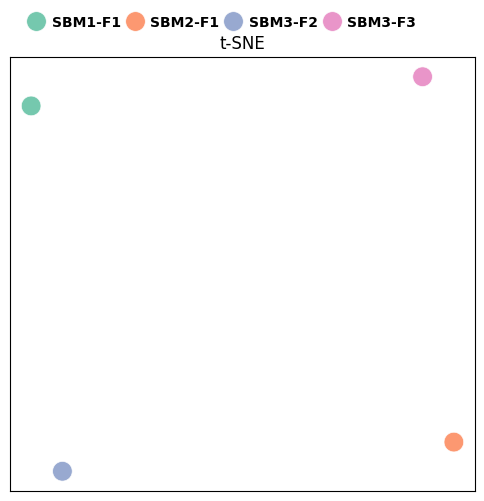

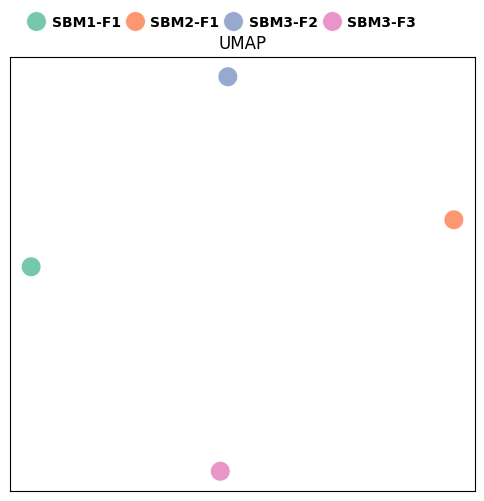

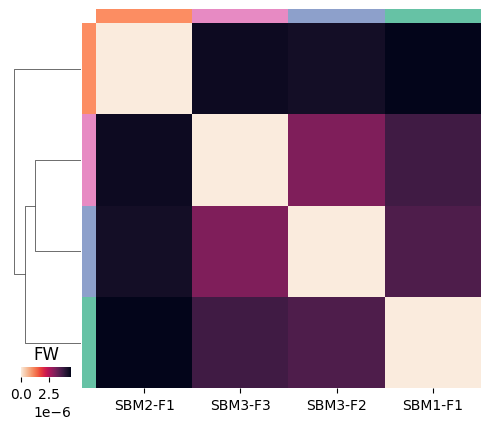

Fused Wasserstein CCB
Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


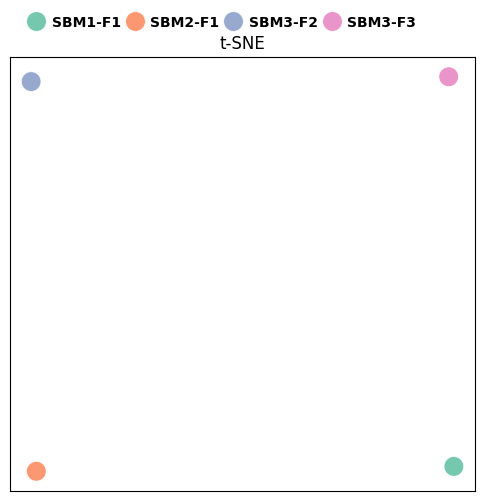

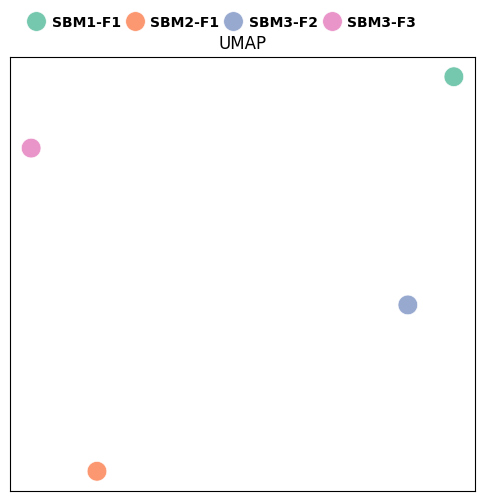

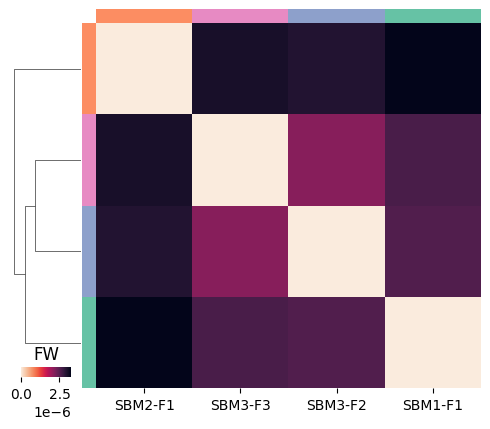

HenHoe2Vec Fused Gromov-Wasserstein
Computing FNGW between all Graph Pairs


DONE: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


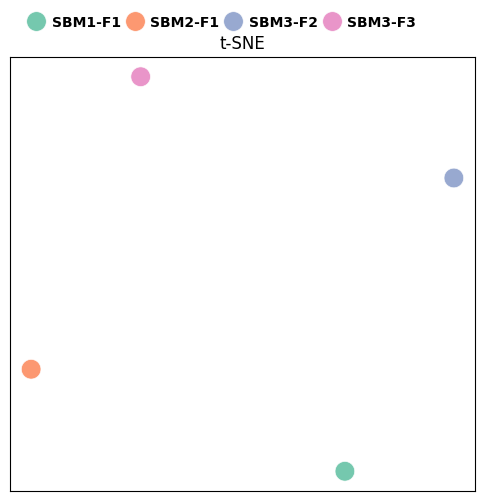

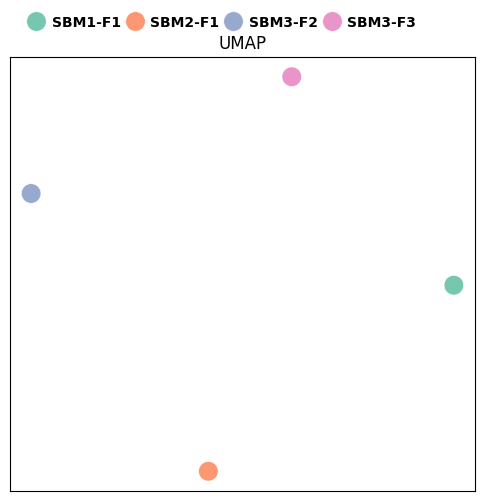

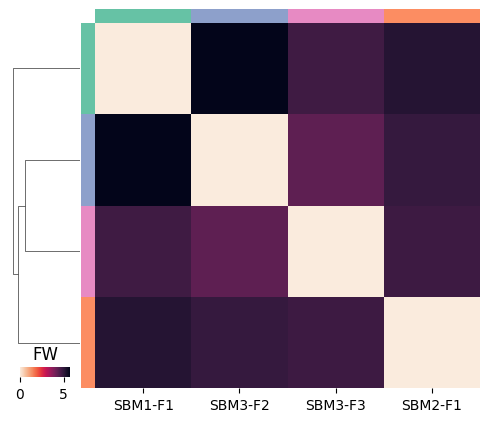

HenHoe2Vec GW
Computing FNGW between all Graph Pairs


DONE: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


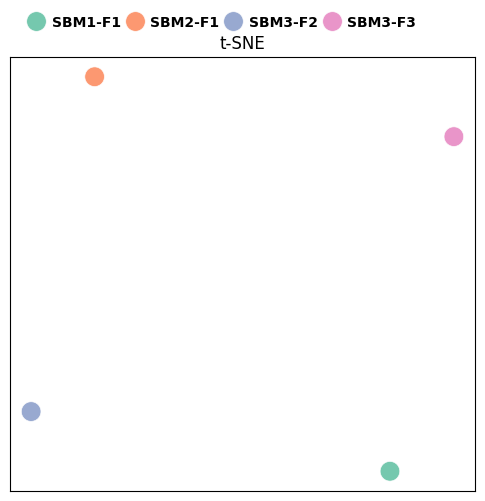

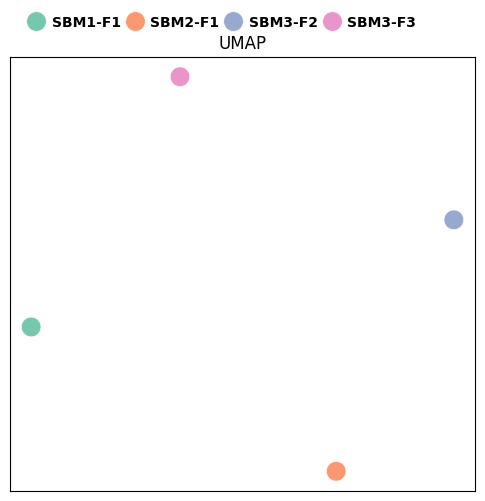

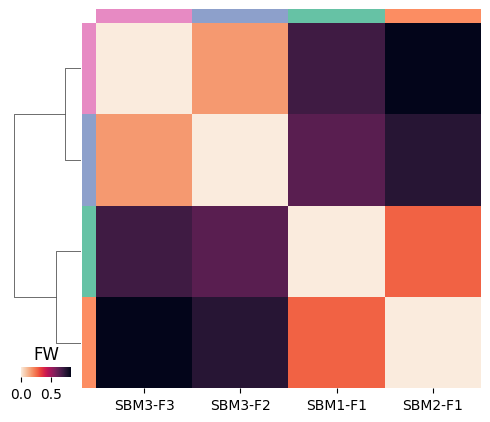

CCB Wasserstein
Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


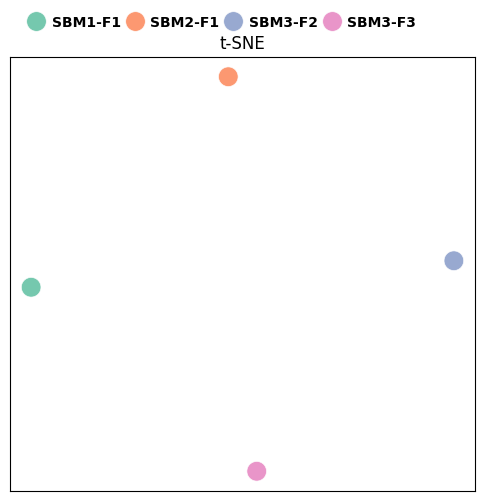

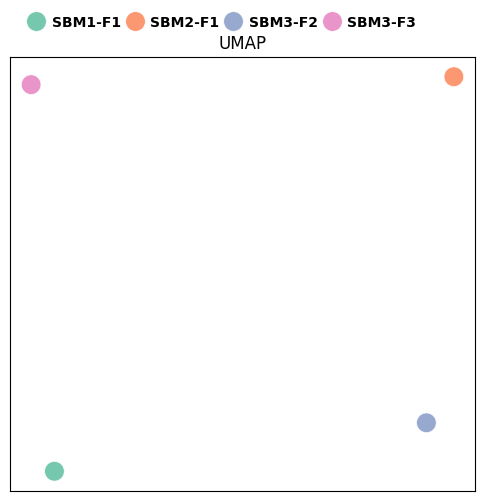

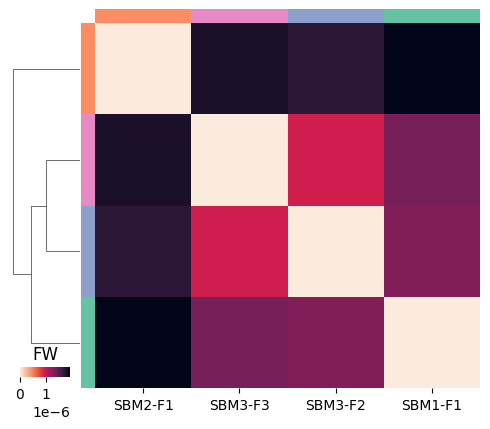

CNP Wasserstein
Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


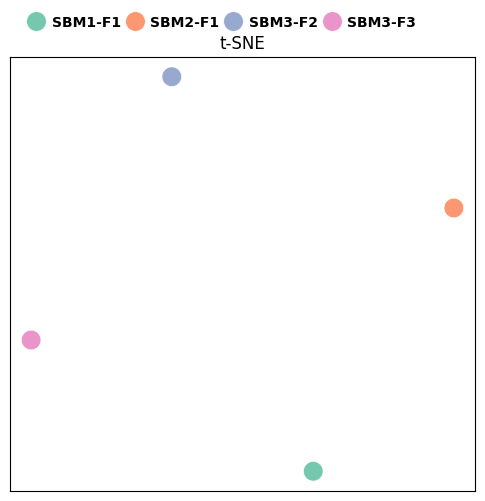

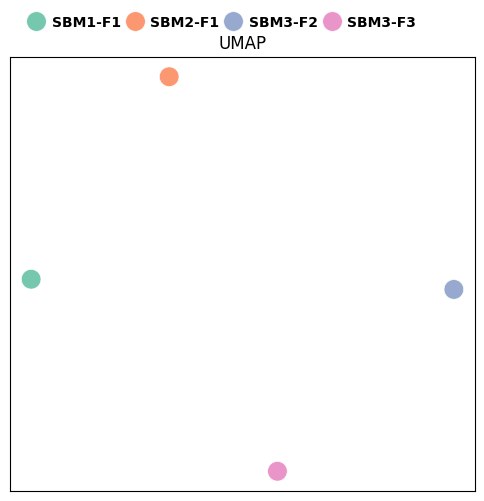

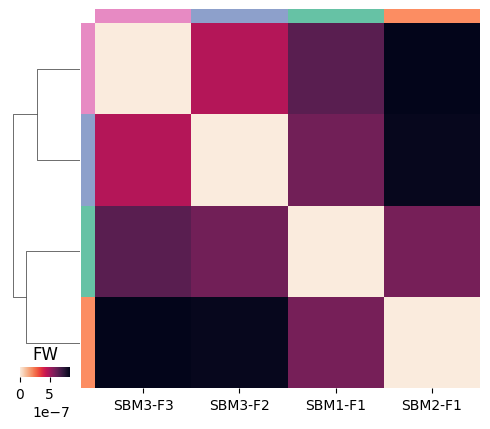

Wasserstein
Precomputing Node Distances between Graphs in respective Structural and Feature Spaces:


DONE: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]

Computing FNGW between all Graph Pairs



DONE: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


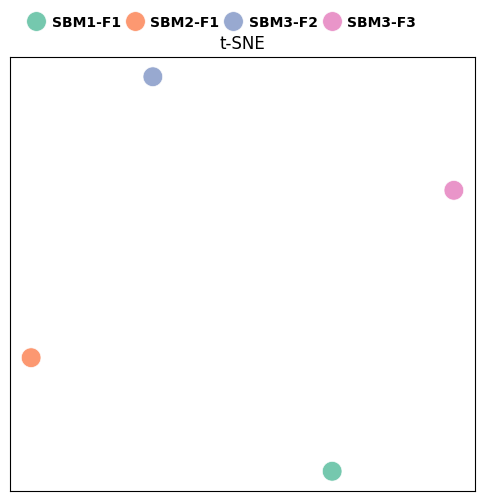

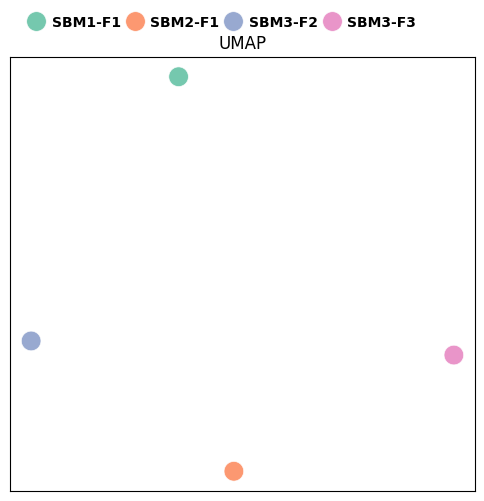

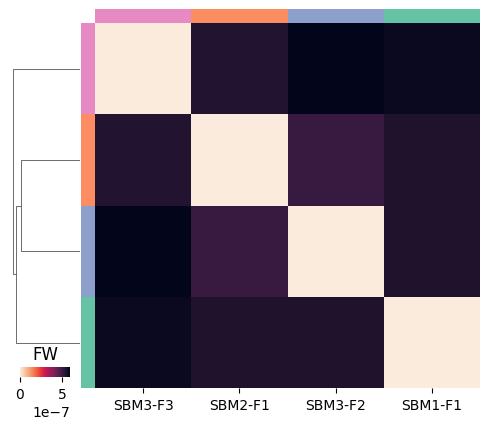

In [ ]:
import time
%load_ext autoreload
%autoreload 2
#Precompute Distances

label_order = None
patient_ids = labels
time_limit = 10
for method, func in methods.items():
    print(method)
    if times.get(method, 0) < time_limit:
        st = time.time()
        precomputed_dists[method], plans[method],struct_cost[method], feat_cost[method] = func() #multiplex_graphs,None,features)
        et = time.time()
        times[method] = et - st
        precomputed_dists[method][precomputed_dists[method]<0] = 0

    #fig, axs = plt.subplots(1,5,figsize=(25,5))
    #plot_heatmap(precomputed_dists[method],patient_ids,ax=axs[0])
    plot_emb(precomputed_dists[method],method='tsne',colors=labels,legend="Top",verbose=True,title="t-SNE",hue_order=label_order,cmap="Set2",annotation=None,s=200)
    #plot_emb(precomputed_dists[method],method='mds',colors=labels,legend="Top",verbose=True,hue_order=label_order,cmap="Set2",annotation=None,s=200)
    plot_emb(precomputed_dists[method],method='umap',colors=labels,legend="Top",title="UMAP",verbose=True,hue_order=label_order,cmap="Set2",annotation=None,s=200)

    hier_clustering(precomputed_dists[method],labels, ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids,dist_name="FW")
    plt.show()


In [ ]:
path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/"
#" #+datetime.now().strftime("%H:%M:%S")
#save_name = "synth_graphs_FW" 

#precomputed_dists_old = precomputed_dists
#precomputed_dists = {key: precomputed_dists_old[key] for key in methods.keys()}

#times_old = times
#times = {key: times_old [key] for key in methods.keys()}


def tri_to_flat(tri_matrix):
    n = tri_matrix.shape[0]
    list = tri_matrix[np.triu_indices(n)].flatten()
    return list
    

def flat_to_tri(list):
    n = int(0.5 * (np.sqrt(8 * len(list) + 1) -1)) #Solves len(flat)= N(N+1)/2 for N
    tri_matrix = np.zeros((n,n))
    ind = np.triu_indices(n)
    tri_matrix[ind] = np.array(list)
    return tri_matrix


if False:
    method_name = f"CCB-TiedW_a0.5"
    np.savez(path+name+"graph_dists.npz",precomputed_dists[method_name])
    np.savez_compressed(path+name+"transport_plans.npz",tri_to_flat(plans[method_name])) 
    np.savez_compressed(path+name+"struct_cost.npz",tri_to_flat(struct_cost[method_name])) 
    np.savez_compressed(path+name+"feat_cost.npz",tri_to_flat(feat_cost[method_name]))

save=True
if save:
    if True: #input(f"Currently saving is set to {save}, please confirm that you want to overwrite disk") =='':
        np.save(path+save_name+"dists.npy",precomputed_dists)
        np.save(path+save_name+"times.npy",times) 
        np.save(path+save_name+"labels.npy",labels)
        np.save(path+save_name+"patientid.npy",patient_ids)

    # = np.load(path+name+"dists.npy",allow_pickle=True).tolist()
    #times = np.load(path+name+"times.npy",allow_pickle=True).tolist()

print(f"Saved under {path+save_name}dists.npy")

Saved under /home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/results/synth_graph_dists_FWdists.npy


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier


def KNN_from_dists(Graphs, labels, precomputed_dists=None, n_splits=20, method="TiedOT",n_neighbors=3,weights=None,test_size=0.1):
    predicted_labels, true_labels, scores, ari = [],[],[],[]


    if n_splits>0:
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size,random_state=0)
        train_test_inds = sss.split(np.zeros(len(Graphs)), labels)
    else:
        #Train = Test
        train_test_inds = [(np.arange(len(Graphs)),np.arange(len(Graphs)))]  #, np.arange(len(Graphs)))

    for i, (train_index, test_index) in enumerate(train_test_inds):
        if precomputed_dists is None:
            train_dists = compute_dists([Graphs[t] for t in train_index],None,method=method)
            test_to_train_dists = compute_dists([Graphs[t] for t in test_index],[Graphs[t] for t in train_index],method=method)
        else:
            train_dists = get_dist_precomputed(precomputed_dists, train_index, train_index)
            test_to_train_dists = get_dist_precomputed(precomputed_dists, test_index, train_index)

        
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors, metric="precomputed",weights=weights)
        neigh.fit(train_dists,[labels[t] for t in train_index])

        predicted_labels.append(neigh.predict(test_to_train_dists))
        true_labels.append(np.asarray([labels[t] for t in test_index]))
        scores.append(neigh.score(test_to_train_dists,true_labels[-1]))
        ari.append(adjusted_rand_score(predicted_labels[-1],true_labels[-1]))


    return predicted_labels, true_labels, scores, ari


def compute_dists(Graphs,Graphs2=None, method="TiedOT"):
    dist, plan = methods[method](Graphs,Graphs2)
    dist[dist<0] = 0
    return dist

def get_dist_precomputed(precomputed_dists, ind1, ind2):
    return precomputed_dists[ind1,:][:,ind2]

def plot_1split(predicted, true,title=None,ax=None):
    annot_labels_ind =np.unique(true,return_index=True)[1]
    annot_labels = true[annot_labels_ind]
    #ind
    cf_matrix = confusion_matrix(true, predicted, labels=annot_labels)
    if ax is None:
        plt.figure()
    ax = sns.heatmap(cf_matrix, annot=True, #fmt='.0', 
            cmap='Blues', xticklabels=annot_labels,yticklabels=annot_labels,ax=ax,fmt='g')
    ax.set(xlabel="Predicted Label", ylabel="True Label")
    ax.set_title(title)

def plot_table(df,tranpose=False):
    format_df = df
    format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))


def np_unique_indices(arr, **kwargs):
    """Unique indices for N-D arrays."""
    arr = np.asarray(arr)
    vals, indices, *others = np_unique_indices_1d(arr.reshape(-1), **kwargs)
    indices = [list(np.stack(np.unravel_index(x, arr.shape))) for x in indices]

    indices = [list(i[0]) for i in indices]
    return vals, indices, *others


def np_unique_indices_1d(arr, **kwargs):
    """Unique indices for 1D arrays."""
    sort_indices = np.argsort(arr)
    arr = np.asarray(arr)[sort_indices]
    vals, first_indices, *others = np.unique(
        arr, return_index=True, **kwargs
    )
    indices = np.split(sort_indices, first_indices[1:])
    for x in indices:
        x.sort()
    return vals, list(indices), *others
    

In [ ]:
avg_emb_times = {emb:np.mean(emb_times[emb]) for emb in emb_times}

ValueError: Number of labels is 4. Valid values are 2 to n_samples - 1 (inclusive)

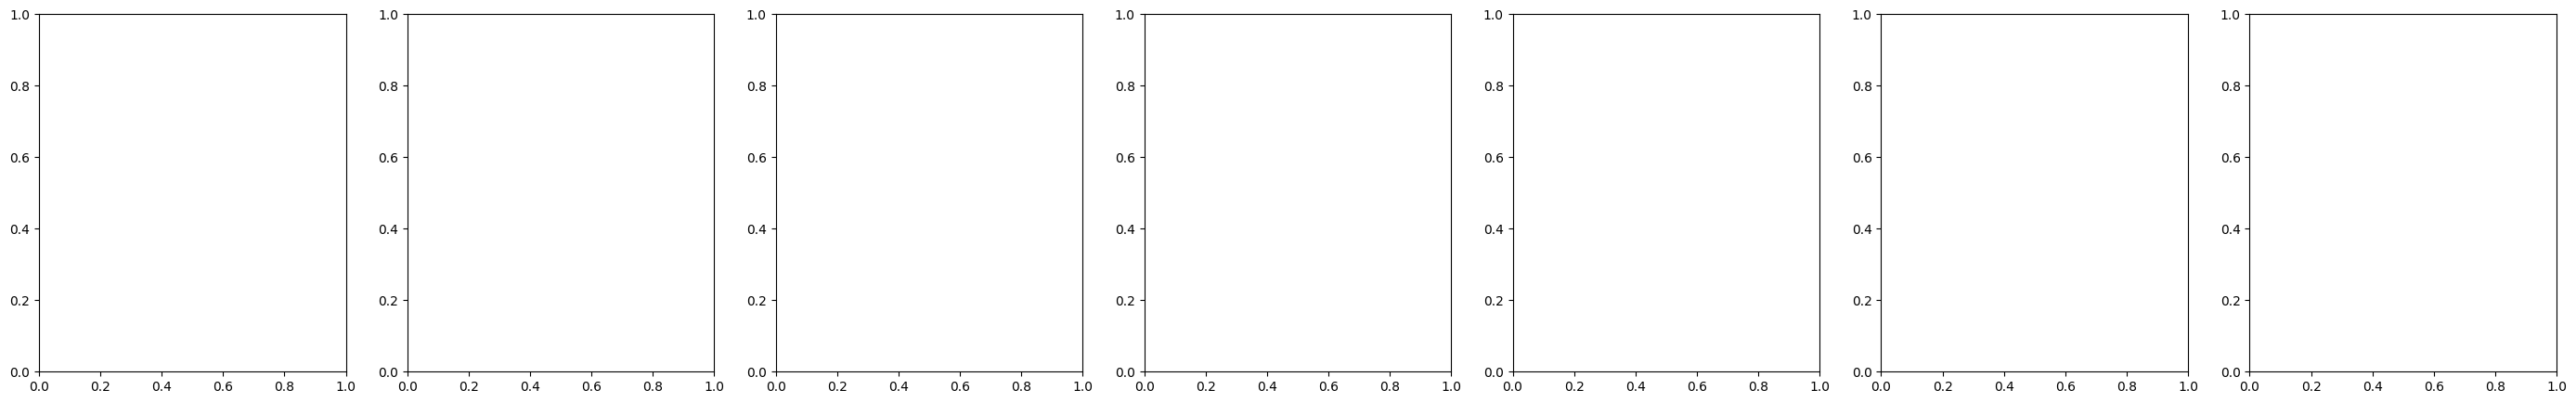

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn
import scipy as sp


import cdlib
from cdlib import NodeClustering
from scipy.cluster import hierarchy

# Weighted
#KNN over precomputed distances
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)



results = {"method":[],
           #"KNN T=0.75":[],
           #"KNN T=0.1":[],
           "ARI":[],
           "VarInf":[],
           
           "Time":[]}

#for m, (method, dist) in enumerate(precomputed_dists.items()):
for m, (method, func) in enumerate(methods.items()):
    dist = precomputed_dists[method]
    #pred, true, score, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.25,n_splits=100)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    zero_dia_dists = precomputed_dists[method]
    np.fill_diagonal(zero_dia_dists,0)
    sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    #ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)),metric='precomputed',linkage='average').fit_predict(precomputed_dists[method])
    ari = sklearn.metrics.adjusted_rand_score(labels,pred_cluster)
    print(ari)

    link = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(dist), method='average', optimal_ordering=True)
    pred_cluster = sp.cluster.hierarchy.fcluster(link,t=len(np.unique(labels)),criterion="maxclust")
    ari = sklearn.metrics.adjusted_rand_score(labels,pred_cluster)
    print(pred_cluster)


    _ , grouped_labels = np_unique_indices(labels) #[np.where([labels==l]) for l in np.unique(labels)]
    _ , grouped_clust = np_unique_indices(pred_cluster) #[np.where([pred_cluster==l]) for l in np.unique(pred_cluster)]
    print(grouped_labels)
    print(grouped_clust)
    truth = NodeClustering(grouped_labels, graph=None, method_name="Pathological labels")
    pred = NodeClustering(grouped_clust, graph=None, method_name="Predicted Cluster")
    eval = cdlib.evaluation.variation_of_information(truth,pred)

    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    #results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    #results["KNN T=0.1"].append(f"{np.average(score2):.2f}±{np.std(score2):.2f}")

    results["ARI"].append(f"{np.average(ari):.2f}")
    results["VarInf"].append(eval[0])
    #results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    results["Time"].append(f"{times[method]/(len(ccb_emb[0])*(len(ccb_emb[0])-1)/2) * 1000: .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))

print(avg_emb_times)




In [ ]:
import os
#new plotting of celltype spatial distributions

%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/paper/plots/celltypes_spats/" 

annotation_image_path = "/home/kuehn/G4P_clean/2024-fused-wasserstein-multimodal-graph-optimal-transport-based-on-probabilistic-node-embeddings-with-application-in-genomics-and-transcriptomics/data/images/celltype_spatial_distribution/2Celltypes/"
considered_celltypes = [f.name for f in os.scandir(annotation_image_path) if f.is_dir()]

for m, (method, func) in enumerate(methods.items()):
    #if True:
    if method == "FW_1/3":
        
        dist =  precomputed_dists[method] #precomputed_dists[method.replace("/","_")] =
        method = method.replace("/","_")
    
        #emb = None
        for c in considered_celltypes:
            print(c)
            celltype_anno_paths = [annotation_image_path+c+f"/ID{id.replace('CK','')}.png" for id in patient_ids] 
            emb = plot_emb(dist,precomputed_emb=emb,s=300,title=c,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_{c}_diffusionmap.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_path=celltype_anno_paths ) #,cmap=cmap_dict)
            plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

%load_ext autoreload
%autoreload 2
save_folder = "/home/kuehn/CNP_OT/cnp-ot/paper/figures/myocardial" 
frames_emb_phate = []
frames_emb_mds = []
frames_dists = []
frames_dists_cluster = []


for m, (method, func) in enumerate(methods.items()):
#if True:
    if "FW" in method:
        
        precomputed_dists[method.replace("/","_")] = precomputed_dists[method]
        method = method.replace("/","_")
    #if "CCB-TiedW_a0.40" in method:
#    method="CCB-TiedW"
  # np-array needed for later indexing

        

    #ordered_dists = np.roll(ordered_dists,-200,axis=(0,1))
        dist = precomputed_dists[method]

    #ordered_dists[:800,:800] = precomputed_dists[method][200:,200:] 
    #ordered_dists[800:,:] = precomputed_dists[method][:200,:] 
    #ordered_dists[:,800:] = precomputed_dists[method][:,:200] 
    
        print(method)

    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=True,save_path=f"{save_folder}/log_mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=False,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}.png",cmap='tab20')
    
    #fig = hier_clustering(precomputed_dists[method],labels, ax=None, cluster=True,title="",dist_name=method+" distance",log=False,save_path=f"{save_folder}/mice_{method}_cluster.png",cmap='tab20')

    #colors = sns.color_palette("Paired") #palette=cmap,n_colors=len(unique_labels))
    #cmap_dict = dict(LS=colors[0], RS=colors[1], LR=colors[2], RR=colors[3], DMN=colors[6]) 
        frames_emb_phate.append(f"{save_folder}/{method}_diffusion_projection_high_res.pdf")

        frames_emb_mds.append(f"{save_folder}/{method}_mds_projection.png")
        frames_dists.append(f"{save_folder}/{method}_dists.png")
        frames_dists_cluster.append(f"{save_folder}/{method}_dists_cluster.png")

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=frames_emb_mds[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)

        plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,hue_order=label_order,cmap="Set2",annotation=patient_ids) 
        plt.show()
        emb = plot_emb(dist,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_histoslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_image_paths) #,cmap=cmap_dict)
        plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,save_path=f"{save_folder}/{method}_diffusion_projection_high_res_nicheslides+withNorm.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_niches_paths) #,cmap=cmap_dict)
        
        fig = hier_clustering(dist,labels, method="ward", ax=None, cluster=True,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists_cluster[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
        
        
        labels_ = list(map(lambda x: label_order.index(x), labels))  # remark: py3 would work different here
        inds = np.argsort(list(labels_))
        ordered_labels = np.asarray(labels)[inds] #[200:] + labels[:200]
        ordered_dists =  dist[inds,:][:,inds]
        fig = hier_clustering(ordered_dists,ordered_labels, method="ward", ax=None, cluster=False,title=method,dist_name="CBB-TiedW",log=False,save_path=frames_dists[-1],hue_order=label_order,cmap="Set2",annotation=patient_ids) #,cmap=cmap_dict)
 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext autoreload
%autoreload 2

plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,s=250,save_path=f"{save_folder}/trajectory/{method}_diffusion_projection_high_res_histoslides.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_image_paths) #,cmap=cmap_dict)
plot_emb(dist,precomputed_emb=emb,method='diffusion',colors=labels,symbols=None,ax=None,s=250,save_path=f"{save_folder}/trajectory/{method}_diffusion_projection_high_res_nicheslides.pdf",hue_order=label_order,cmap="Set2",annotation=patient_ids, annotation_image_paths=annotation_niches_paths) #,cmap=cmap_dict)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'emb' is not defined

In [ ]:
   
import imageio

# Order of images
#with imageio.get_writer(f"{save_folder}/dists_animation.gif", mode='I') as writer:
#    for filename in frames_dists:
#        image = imageio.imread(filename)
#        writer.append_data(image)


def frames2ani(frames,path,fps=0.01):
    print(frames)
    images = list(map(lambda frame: imageio.imread(frame), frames))

    imageio.mimsave(path, images, duration = len(frames) *1/fps) 

frames2ani(frames_dists,f"{save_folder}/dists_animation.gif")
frames2ani(frames_emb_phate,f"{save_folder}/phate_emb_animation.gif")
frames2ani(frames_emb_mds,f"{save_folder}/mds_emb_animation.gif")
#with imageio.get_writer(f"{save_folder}/emb_animation.gif", mode='I') as writer:
#    for filename in frames_emb:
#        image = imageio.imread(filename)
#        writer.append_data(image)
#images = list(map(lambda filename: imageio.imread(filename), filenames))
#imageio.mimsave(f"{save_folder}/emb_animation.gif", frames_emb, duration = 1) 

[]


ValueError: need at least one array to stack

In [ ]:
singleCell_df = sc.read_h5ad("/home/kuehn/G4P/data/myocardial_infarction/multilayer/single_cell_level/scRNA/snRNAseq_cellsWithSubtype50000cells.h5ad")

def getCellInds(patient):
    return np.where(singleCell_df.obs["patient_region_id"] == patient)[0]   
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
